## Remove donor RB1048 from batch 2, and add in RB1071.
Old batch:   
RB1060+RB1003  
RB1048+RB1065  


In [1]:
donors_init = ["RB1060", "RB1003", "RB1048", "RB1065"]

## Since the algorithm works with even divisions in each multiplex, I am going to keep the donor in, but when looking for the best fit I will remove their features for the comparison (and also need to make sure that donor cannot be in the 4 person batch either o.w would be one subject)

In [2]:
donor_to_drop = "RB1002"

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join, exists
import os
%matplotlib inline
from itertools import combinations
from collections import defaultdict 
from src.config import ROOT_DIR, DATA_DIR
from scipy.stats import ttest_ind, chisquare
import tqdm
from copy import deepcopy

Project Directory: /data2/mito_lineage


In [4]:
np.random.seed(42)

In [5]:
outdir = "./output"
out_f = "Chipd10_secondRun"

In [6]:
if not exists(outdir):
    os.mkdir(outdir)

## Set up parameters for the number of subjects in a batch (day) and number of donors in each multiplex

In [7]:
n_sim=10000
batches=[3,2] #,4]
#mult=[3,2]

In [8]:
in_f = join(DATA_DIR, "processed", "gilead_chip_profile/CHIPd10", "CHIPd10donor_feature.csv")
donor_meta = pd.read_csv(in_f, index_col=0)
donor_meta

,Sum_VAF,Smoking_Status,Cell_count__viability,Age,Gender,Race
Donor_ID,,,,,,
RB1046,0.546006,0,2870000,53,M,Hispanic
RB1085,0.154719,0,700000,53,F,Hispanic
RB1071,0.141314,0,1600000,54,M,Caucasian
RB1060,0.469024,1,1700000,51,M,Caucasian
RB1065,1.733630,1,1700000,53,F,African_American
RB1002,NaN,1,1300000,50,M,Asian
RB1003,0.014966,0,1090000,64,M,Caucasian
RB1048,0.719311,0,2230000,61,M,Asian
RB1138,0.006915,0,1240000,55,F,African_American


### Sum_VAF is the sum VAF across all CHIP mutations in a donor

## Preprocess and clean df 
make gender and race categorical. 

In [9]:
race_map = {"Hispanic":0, "Caucasian":1, "African_American":2, "Asian":3}
donor_meta["Race"] = donor_meta["Race"].map(race_map)
gend_map ={"M":0,"F":1}
donor_meta["Gender"] = donor_meta["Gender"].map(gend_map)



## Remove donors from batch 1 and the filtered sample

In [10]:
donor_meta = donor_meta.loc[~(donor_meta.index.isin(donors_init+[donor_to_drop]))]

In [11]:
donor_meta = donor_meta.reset_index()

## B. Sample n_sim times an ordering of donors and store into sim_d

In [12]:
def single_run(sample, batches):
    """ Given a permutation sample & lists of batches and multiplex, will partition donors based on ordering.
    
    """
    #print('sample', sample)
    sim = pd.DataFrame(index=np.arange(len(sample)), columns=["batch"], )
    sim.index.name = "donor"
    for b_ind, b in enumerate(batches):
        curr_b = sample[sum(batches[:b_ind]):sum(batches[:b_ind])+b]
        #print("b_ind", b_ind)
        #print('curr_b', curr_b)
        #print('m_batches', m_batches)
        sim.loc[curr_b, "batch"] = b_ind
    return sim

def wrap(n_sim, batches, n_donors=5):
    sim_d={}
    for n in range(n_sim):
        curr = np.random.permutation(n_donors)
        sim_d[n] = single_run(curr, batches)
    return pd.concat(sim_d).reset_index().rename({"level_0":"sim"}, axis=1)

sim_d = wrap(n_sim, batches=batches)
sim_d

,sim,donor,batch
0,0,0,1
1,0,1,0
2,0,2,0
3,0,3,1
4,0,4,0
...,...,...,...
49995,9999,0,0
49996,9999,1,0
49997,9999,2,1
49998,9999,3,0


## C. For each sampled plate layout, calculate the t-test and/or Chi-square p-value between the two different batches (higher value means samples are more evenly mixed)
(If >2 plates, will need to do Anova instead)

In [13]:
sim_ttest = pd.DataFrame(index=np.arange(n_sim),columns=donor_meta.drop("Donor_ID",axis=1).columns)
for s, df in sim_d.groupby("sim"):
    curr_sol = pd.concat((df.set_index("donor"),donor_meta.reset_index()), axis=1)
    for f in donor_meta.drop("Donor_ID",axis=1).columns: #sim_ttest.append(ttest_ind(df[df["batch"]==0], df[df["batch"]==1]))
        try:
            sim_ttest.loc[s, f]=ttest_ind(curr_sol[curr_sol["batch"]==0][f].fillna(0), curr_sol[curr_sol["batch"]==1][f].fillna(0))[1]
        except TypeError:
            sim_ttest.loc[s, f]=chisquare(curr_sol[curr_sol["batch"]==0][f], curr_sol[curr_sol["batch"]==1][f])[1]

## D. Plot the distributions of the p-value results across each feature 

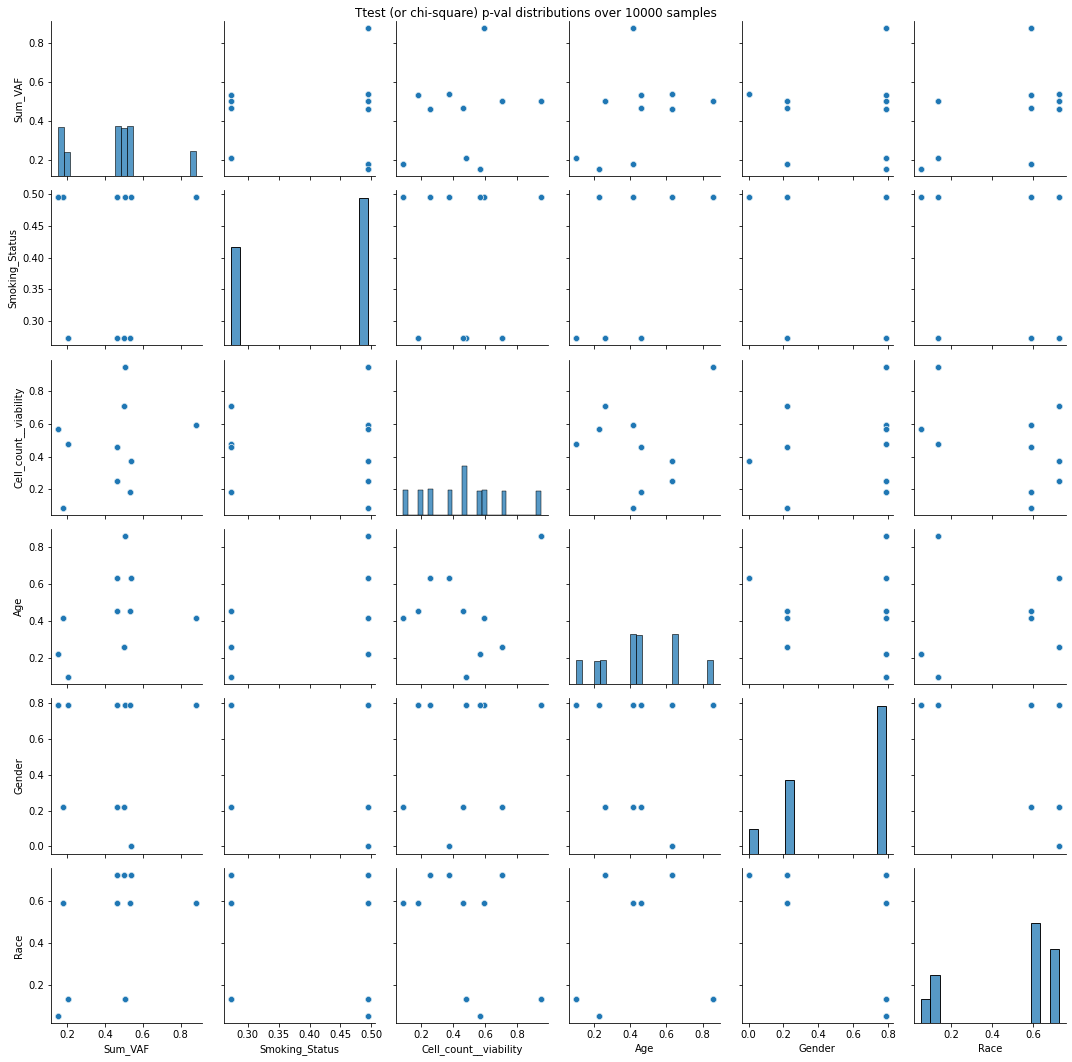

In [14]:
%matplotlib inline
sns.pairplot(sim_ttest)
plt.suptitle("Ttest (or chi-square) p-val distributions over 10000 samples")
plt.tight_layout()

In [15]:
sim_ttest

,Sum_VAF,Smoking_Status,Cell_count__viability,Age,Gender,Race
0,0.464063,0.495025,0.25178,0.631991,0.78878,0.724377
1,0.466406,0.272228,0.458706,0.458483,0.219102,0.590801
2,0.502832,0.272228,0.706897,0.261338,0.219102,0.724377
3,0.207761,0.272228,0.478158,0.099114,0.78878,0.132842
4,0.535275,0.272228,0.180375,0.458483,0.78878,0.590801
...,...,...,...,...,...,...
9995,0.464063,0.495025,0.25178,0.631991,0.78878,0.724377
9996,0.152895,0.495025,0.567052,0.225538,0.78878,0.0533627
9997,0.505215,0.495025,0.950154,0.860245,0.78878,0.132842
9998,0.535275,0.272228,0.180375,0.458483,0.78878,0.590801


# Aggregate scoring with weighting

In [16]:
weights = {"Sum_VAF":2, "Cell_count__viability":1.8, 
           "Smoking_Status":1.5, "Age":1, "Gender":1}

scores = sim_ttest.apply(lambda x: sum([x[w]*weights[w] if (not np.isnan(x[w])) else 0 for w in weights]), axis=1)

scores
# best_df

0       3.544640
1       2.844411
2       3.166861
3       2.572443
4       3.050830
          ...   
9995    3.544640
9996    3.083339
9997    5.112270
9998    3.050830
9999    3.166861
Length: 10000, dtype: float64

6339


<Figure size 432x288 with 0 Axes>

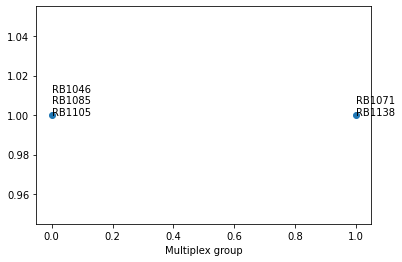

In [17]:
%matplotlib inline
best_sim = scores.sort_values(ascending=False).index[0]
print(best_sim)
best_df = sim_d.loc[sim_d["sim"]==best_sim]
best_df

# Best fit layout

x = []
txt = []
f = plt.figure()
for ind, val in best_df.groupby("batch"):
    x.append(ind)
    txt.append("\n".join(donor_meta.loc[val["donor"], "Donor_ID"].dropna().values))

fig, ax = plt.subplots()
ax.scatter(x,[1]*len(x))
for i, t in enumerate(txt):
    ax.annotate(t, (x[i],1))
    
plt.xlabel("Multiplex group")

plt.savefig(join(outdir, f"{out_f}_best_experiment_layout.pdf"), bbox_inches='tight')


Sum_VAF
Smoking_Status
Cell_count__viability
Age
Gender
Race


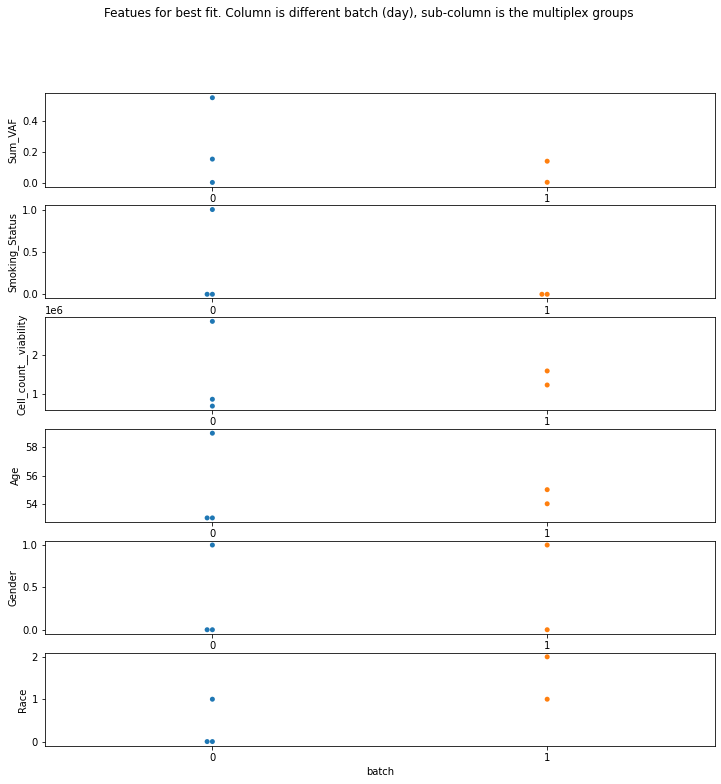

In [18]:
count=0
#n_batch = len(best_df["batch"].unique())
f, ax = plt.subplots(nrows=len(donor_meta.columns)-1, figsize=(12,12))
best_in = pd.concat((best_df.set_index("donor"), donor_meta),axis=1)
for feat in donor_meta.drop("Donor_ID",axis=1).columns:
    print(feat)
    #for b in range(n_batch):        
    sns.swarmplot(data=best_in, y=feat, x = "batch",
                 ax=ax[count])
    plt.suptitle("Featues for best fit. Column is different batch (day), sub-column is the multiplex groups")
    count+=1

plt.savefig(join(outdir, f"{out_f}_best_experiment_features.pdf"))


In [19]:
outdir

'./output'

In [20]:
pwd

'/data2/mito_lineage/notebooks/exp_design'